In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential 
from keras.layers import Dense
from keras.optimizers import SGD


keras.utils.set_random_seed(12)


2024-01-09 18:34:25.252954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 18:34:25.253034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 18:34:25.288987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 18:34:25.377078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 18:34:26.515714: W tensorflow/compiler/tf2

## MONK 3

In [3]:
path=r'/home/ludovico/ML-project/data/monks-3'

#importing training and test set
monk3_train = pd.read_csv(path+'.train', header=None, delim_whitespace=True, dtype=str)
monk3_test = pd.read_csv(path+'.test', header=None, delim_whitespace=True, dtype=str)

#separating input from target
y_train=monk3_train[0]
x_train=monk3_train[monk3_train.columns[1:-1]]
y_test=monk3_test[0]
x_test=monk3_test[monk3_train.columns[1:-1]]

# encoded data
encoder = OneHotEncoder(sparse_output=False)
x_train = encoder.fit_transform(x_train)
x_test = encoder.fit_transform(x_test)

## Creating the network using Keras 
We add 1 hidden layer with 17 (x_train.shape[1]) number of input units, dens_nparams number of units in the hidden layer, SGD as optimizer algorithm and 1 output unit with sigmoid activation function. 

In [4]:
def create_model(init='uniform', activation='relu', nbr_features=17, dense_nparams=10,lr=0.01,momentum=0.1,w_d=0.0001, nest=False):
    model = Sequential()
    model.add(Dense(dense_nparams, activation, input_shape=(nbr_features,), kernel_initializer=init,)) 
    model.add(Dense(1, activation='sigmoid',kernel_initializer=init))
    model.compile(loss='binary_crossentropy', optimizer=SGD(lr,momentum,nest,w_d),metrics=["accuracy"])
    return model

# callback to use earlystopping 
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3)

kears_estimator = KerasClassifier(model=create_model,verbose=0)

## Model selection

In [5]:
param_grid = {
    'epochs': [300],
    'model__dense_nparams': [5],
    'model__init': [ 'normal' ], 
    'batch_size':[100],
    'model__lr':[0.05],
    'model__momentum':[0.7],
    'model__w_d':[0.1]
    
}

grid_search = GridSearchCV(estimator=kears_estimator,  
                    n_jobs=-1, 
                    verbose=3,
                    return_train_score=True,
                    scoring='accuracy',
                    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0),
                    param_grid=param_grid,
                    )

MLP=grid_search.fit(x_train, y_train)

Fitting 25 folds for each of 1 candidates, totalling 25 fits


2024-01-09 18:35:05.682651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 18:35:05.682923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 18:35:05.684025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 18:35:05.692576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 18:35:05.713588: E external/local_xla/xla/

[CV 4/25] END batch_size=100, epochs=300, model__dense_nparams=5, model__init=normal, model__lr=0.05, model__momentum=0.7, model__w_d=0.1;, score=(train=0.959, test=0.833) total time=   3.0s
[CV 5/25] END batch_size=100, epochs=300, model__dense_nparams=5, model__init=normal, model__lr=0.05, model__momentum=0.7, model__w_d=0.1;, score=(train=0.918, test=0.958) total time=   3.0s
[CV 7/25] END batch_size=100, epochs=300, model__dense_nparams=5, model__init=normal, model__lr=0.05, model__momentum=0.7, model__w_d=0.1;, score=(train=0.938, test=0.920) total time=   3.0s
[CV 8/25] END batch_size=100, epochs=300, model__dense_nparams=5, model__init=normal, model__lr=0.05, model__momentum=0.7, model__w_d=0.1;, score=(train=0.929, test=0.958) total time=   3.1s
[CV 1/25] END batch_size=100, epochs=300, model__dense_nparams=5, model__init=normal, model__lr=0.05, model__momentum=0.7, model__w_d=0.1;, score=(train=0.928, test=0.960) total time=   3.2s
[CV 3/25] END batch_size=100, epochs=300, mod

### Evaluating the MLP classifier 

In [6]:
cv_results_df = pd.DataFrame(MLP.cv_results_)
best_model_index=MLP.best_index_

print('best params',MLP.best_params_) 

val_loss=cv_results_df['mean_test_score'][best_model_index]
val_std=cv_results_df['std_test_score'][best_model_index]
train_loss=cv_results_df['mean_train_score'][best_model_index]
train_std=cv_results_df['std_train_score'][best_model_index]
print('Train acc:',train_loss,'+/-', train_std)
print('Validation acc:',val_loss,'+/-', val_std)

cv_results_df

best params {'batch_size': 100, 'epochs': 300, 'model__dense_nparams': 5, 'model__init': 'normal', 'model__lr': 0.05, 'model__momentum': 0.7, 'model__w_d': 0.1}
Train acc: 0.9348243214811699 +/- 0.013903459198782003
Validation acc: 0.9292666666666666 +/- 0.052894192077727734


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_model__dense_nparams,param_model__init,param_model__lr,param_model__momentum,...,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,mean_train_score,std_train_score
0,2.993443,0.338849,0.153029,0.047552,100,300,5,normal,0.05,0.7,...,0.938776,0.928571,0.928571,0.927835,0.927835,0.969388,0.918367,0.928571,0.934824,0.013903


## Learning curve

Epoch 1/300
1/1 [==============================] - 1s 502ms/step - loss: 0.6933 - accuracy: 0.4433 - val_loss: 0.6934 - val_accuracy: 0.5600
Epoch 2/300
1/1 [==============================] - 0s 23ms/step - loss: 0.6933 - accuracy: 0.4536 - val_loss: 0.6933 - val_accuracy: 0.5600
Epoch 3/300
1/1 [==============================] - 0s 25ms/step - loss: 0.6933 - accuracy: 0.4536 - val_loss: 0.6933 - val_accuracy: 0.5600
Epoch 4/300
1/1 [==============================] - 0s 26ms/step - loss: 0.6932 - accuracy: 0.4639 - val_loss: 0.6932 - val_accuracy: 0.5600
Epoch 5/300
1/1 [==============================] - 0s 24ms/step - loss: 0.6932 - accuracy: 0.4845 - val_loss: 0.6932 - val_accuracy: 0.5200
Epoch 6/300
1/1 [==============================] - 0s 28ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6931 - val_accuracy: 0.5200
Epoch 7/300
1/1 [==============================] - 0s 24ms/step - loss: 0.6931 - accuracy: 0.4948 - val_loss: 0.6931 - val_accuracy: 0.5200
Epoch 8/300
1/1 [==

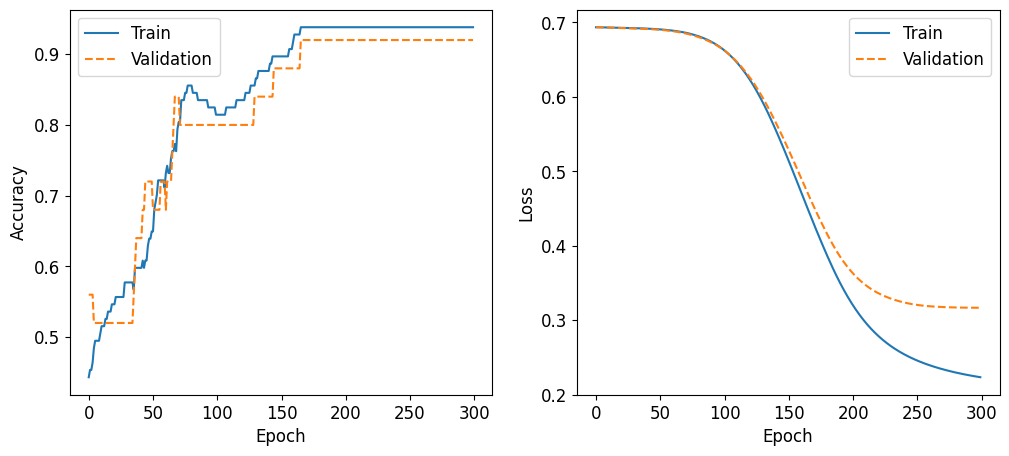

In [12]:
keras.utils.set_random_seed(42)
x_train_cl, x_val, y_train_cl, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0, stratify=y_train, shuffle=True)

model=KerasClassifier(model=create_model,**grid_search.best_params_)
history = model.fit(x_train_cl, y_train_cl.astype(np.float32),validation_data=(x_val,y_val.astype(np.float32)))

# list all data in history

plt.rcParams.update({'font.size': 12})

print(history.history_.keys())
# summarize history for accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history_['accuracy'])
plt.plot(history.history_['val_accuracy'], linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history_['loss'])
plt.plot(history.history_['val_loss'], linestyle='--')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

## Model assessment

Accuracy Score - Test-error: 0.9722222222222222

 Classification report               precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



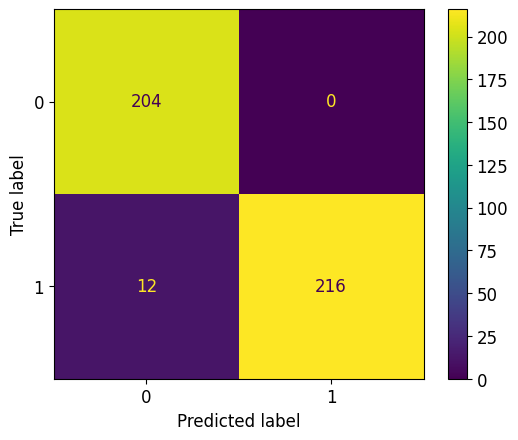

In [9]:
y_pred =MLP.predict(x_test)

print('Accuracy Score - Test-error:', metrics.accuracy_score(y_test, y_pred))  

print('\n Classification report',metrics.classification_report(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred, labels=MLP.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=MLP.classes_)
disp.plot()
plt.show()